In [182]:
from skimage import io
from skimage import color
from skimage.restoration import denoise_nl_means, estimate_sigma

import numpy as np


from numpy.fft import fft, fftfreq, ifft
from scipy import ndimage as nd
from scipy.fft import fft, ifft
from scipy import fftpack
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time
import cv2
from math import sqrt
from math import exp

In [183]:
def make_line_filter(line_width: int, filter_width: int, filter_height:int):
    assert line_width < filter_width
    filter = np.zeros([filter_height, filter_width], dtype=float)
    half_line_width = int(line_width / 2)
    half_filter_size = int(filter_width / 2)
    line_x_start = half_filter_size - half_line_width
    line_x_end = half_filter_size + half_line_width + 1
    filter[:, line_x_start:line_x_end] = 1
    return filter

In [184]:
# Source: https://gist.github.com/andrewgiessel/4635563
def make_gauss_filter(size, fwhm = 3, center=None):
    """
    Make a square gaussian kernel.

    :param size: the length of a side of the square
    :param fwhm: full-width-half-maximum, which can be thought
     of as an effective radius
    :param center:
    :return:
    """
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def rotate(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by 45 degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

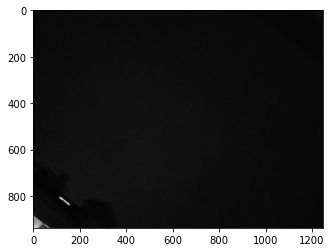

In [185]:
img = cv2.imread("../dataset/honor/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

(937, 1249)

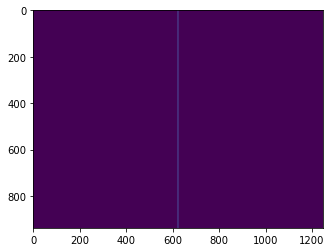

In [186]:
line_filter = make_line_filter(1, filter_width=gray.shape[1], filter_height=gray.shape[0])
plt.imshow(line_filter)
line_filter.shape

(937, 1249)

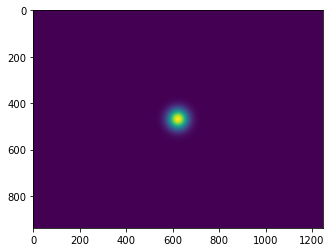

In [187]:
img_height = gray.shape[0]

gauss_filter = make_gauss_filter(gray.shape[1], fwhm=70)
height_to_remove = gauss_filter.shape[0] - img_height
half_height_to_remove = height_to_remove // 2
gauss_filter = gauss_filter[half_height_to_remove:-half_height_to_remove, ...]
plt.imshow(gauss_filter)
gauss_filter.shape

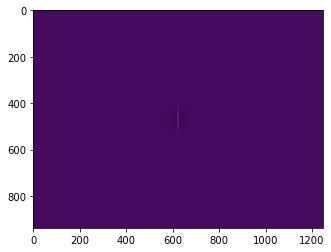

In [188]:
filter = gauss_filter.copy()
filter[line_filter == 0] *= -1
filter[line_filter == 1] *= 32
# normalize
filter /= np.sum(np.abs(filter))
plt.imshow(filter)

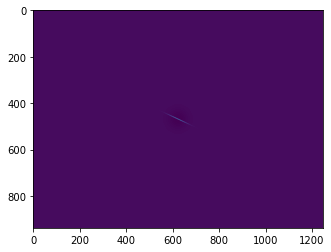

In [189]:
rot_filter = rotate(filter, 65)
plt.imshow(rot_filter)

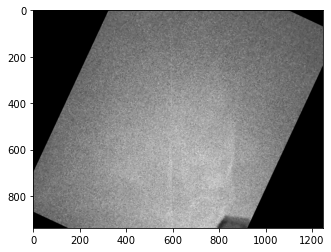

In [190]:
rotated = rotate(gray, 65)
plt.imshow(rotated, cmap='gray')

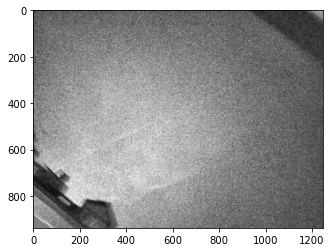

In [191]:
interval = 10
median = np.median(gray)
nobackgr = gray.copy()
nobackgr[nobackgr > median + interval] = median
nobackgr[nobackgr < median - interval] = median
plt.imshow(nobackgr, cmap='gray')

Text(0.5, 1.0, 'Spectrum')

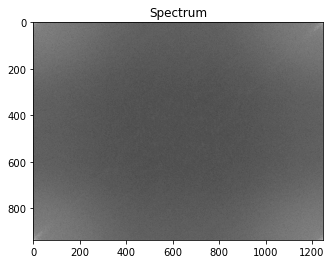

In [192]:
img_spectrum = np.fft.fft2(nobackgr)
plt.imshow(np.log(1+np.abs(img_spectrum)), "gray")
plt.title("Spectrum")

Text(0.5, 1.0, 'Centered Spectrum')

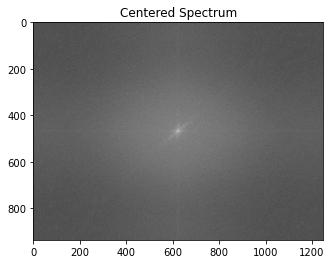

In [193]:
center = np.fft.fftshift(img_spectrum)
plt.imshow(np.log(1+np.abs(center)), "gray")
plt.title("Centered Spectrum")

Text(0.5, 1.0, 'Filter Spectrum')

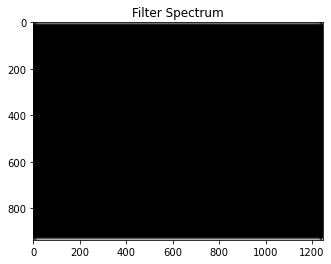

In [194]:
filter_spectrum = np.fft.fft2(filter)
plt.imshow(np.log(1+np.abs(filter_spectrum)), "gray")
plt.title("Filter Spectrum")

Text(0.5, 1.0, 'Centered Filter Spectrum')

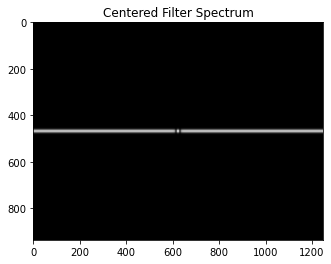

In [195]:
center_filter = np.fft.fftshift(filter_spectrum)
plt.imshow(np.log(1+np.abs(center_filter)), "gray")
plt.title("Centered Filter Spectrum")


Text(0.5, 1.0, 'Processed Image')

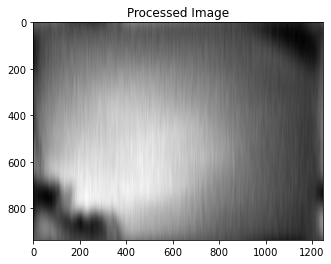

In [196]:
result_spectrum = filter_spectrum * img_spectrum
vertical_lines = np.fft.ifft2(result_spectrum)
vertical_lines = np.fft.ifftshift(vertical_lines)
plt.imshow(np.abs(vertical_lines), "gray")
plt.title("Processed Image")

/home/lada/anaconda3/envs/opencv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


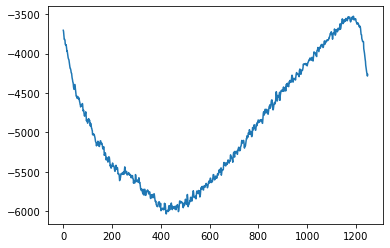

In [197]:
cols = np.sum(vertical_lines, axis=0)
fig, ax = plt.subplots()
ax.plot(cols)

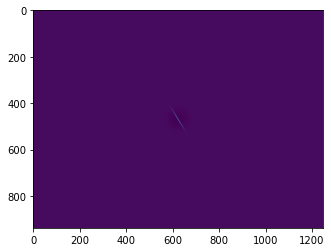

In [198]:
rotations = np.linspace(1, 180, 60)
filters = np.tile(filter[np.newaxis, ...], (rotations.shape[0], 1, 1))
for i in range(rotations.shape[0]):
    filters[i] = rotate(filters[i], rotations[i])
plt.imshow(filters[10])

In [199]:
filters_spectrum = np.empty_like(filters, dtype=complex)
for i in range(filters.shape[0]):
    filters_spectrum[i]  = np.fft.fft2(filters[i])

In [200]:
filtered_images = np.empty_like(filters)
for i in range(filters_spectrum.shape[0]):
    result_spectrum = filters_spectrum[i] * img_spectrum
    lines = np.fft.ifft2(result_spectrum)
    lines = np.fft.ifftshift(lines)
    filtered_images[i] = np.abs(lines)
    #plt.imshow(np.abs(lines), "gray")
    #plt.show()

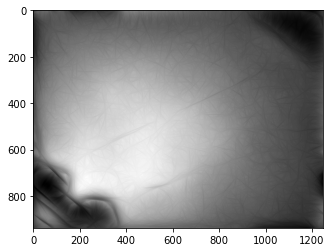

In [211]:
filtered = np.min(filtered_images, axis=0)
plt.imshow(filtered, cmap='gray')
# plt.savefig("../files/honor/1_fft.png")
